## Part 5 of creating auto-populate feature

## Review 'error' in ingredients returned

In [1]:
%%capture
pip install psycopg2

In [2]:
import ast
import psycopg2
from collections import Counter

In [3]:
def string_to_list(x):
    return ast.literal_eval(x)


def ingredient_getter(word):
    if len(word) == 0:
        return {'error': 'nothing entered'}
    else:
        results_list = []
        split_words = word.split()

        if not split_words:
            split_words = "none"

        conn = psycopg2.connect(database ='postgres', user = 'postgres', password = 'tz6MTgxObUZ62MNv0xgp', host = 'mydishdb-dev.c3und8sjo4p2.us-east-2.rds.amazonaws.com', port = '5432')
        cursor = conn.cursor()

        command = f"SELECT * FROM recipes WHERE name ILIKE '%{split_words[0]}%' "
        if len(split_words) > 1:
            for i in range(1, len(split_words)):
                command += f"AND name ILIKE '%{split_words[i]}%' "
        command += ";"

        cursor.execute(command)

        recipe_table = cursor.fetchall()

        cursor.close()
        conn.close()

        # Initialize a Counter for tabulating how often each ingredient occurs
        ingredient_counts = Counter()

        # Count each instance of each ingredient
        for i in range(len(recipe_table)):
            for j in range(2, len(recipe_table[i])):
                if recipe_table[i][j]:
                    ingredient = string_to_list(recipe_table[i][j])[2]
                    ingredient_counts.update({ingredient: 1})

        # Get the top 30 ingredients sorted by most common
        top_30 = sorted(ingredient_counts.items(), key=lambda x: x[1], reverse=True)[:30]

        # Get the ingredients that occured in at least 25% of recipes returned
        above_25_percent = [(tup[0], round(100*tup[1]/len(recipe_table), 1)) for tup in top_30 if 100*tup[1]/len(recipe_table) >= 25]

        # Get the ingredient information and put it in a dictionary
        for item in above_25_percent:
            quantity_list = []
            unit_list = []

            for i in range(len(recipe_table)):

                for j in range(2, len(recipe_table[i])):

                    if recipe_table[i][j]:
                        if string_to_list(recipe_table[i][j])[2] == item[0]:

                            quantity = string_to_list(recipe_table[i][j])[0]
                            unit = string_to_list(recipe_table[i][j])[1]

                            quantity_list.append(quantity)
                            unit_list.append(unit)


            # Getting and saving the most common quantity and unit for each ingredient
            data = Counter(quantity_list)
            quantity = data.most_common(1)
            data = Counter(unit_list)
            unit = data.most_common(1)
            
            ingred_dict = {'quantity': quantity[0][0], 'unit': unit[0][0], 'ingredient': item[0]}

            results_list.append(ingred_dict)

        return results_list
    

In [4]:
ingredient_getter('chocolate chip cookies')

[{'quantity': '1', 'unit': 'teaspoon', 'ingredient': 'vanilla extract'},
 {'quantity': '1', 'unit': 'teaspoon', 'ingredient': 'baking soda'},
 {'quantity': '2', 'unit': 'cups', 'ingredient': 'all-purpose flour'},
 {'quantity': '1', 'unit': 'cup', 'ingredient': 'white sugar'},
 {'quantity': '1/2', 'unit': 'teaspoon', 'ingredient': 'salt'},
 {'quantity': '2', 'unit': None, 'ingredient': 'eggs'},
 {'quantity': '2', 'unit': 'cups', 'ingredient': 'semisweet chocolate chips'},
 {'quantity': '1', 'unit': 'cup', 'ingredient': 'butter, softened'},
 {'quantity': '3/4', 'unit': 'cup', 'ingredient': 'packed brown sugar'},
 {'quantity': '1', 'unit': 'teaspoon', 'ingredient': 'baking powder'}]

### What if nothing is entered

In [5]:
ingredient_getter('')

{'error': 'nothing entered'}

### This cell was to troubleshoot an server error

In [6]:
word = ""
split_words = word.split()

if not split_words:
    split_words = "none"

conn = psycopg2.connect(database ='postgres', user = 'postgres', password = 'tz6MTgxObUZ62MNv0xgp', host = 'mydishdb-dev.c3und8sjo4p2.us-east-2.rds.amazonaws.com', port = '5432')
cursor = conn.cursor()

command = f"SELECT * FROM recipes WHERE name ILIKE '%{split_words[0]}%' "
if len(split_words) > 1:
    for i in range(1, len(split_words)):
        command += f"AND name ILIKE '%{split_words[i]}%' "
command += ";"

cursor.execute(command)

recipe_table = cursor.fetchall()

cursor.close()
conn.close()

### What is symbols are entered

In [7]:
ingredient_getter('# $')

[{'quantity': '1', 'unit': 'pound', 'ingredient': 'ground pork sausage'},
 {'quantity': '1/4', 'unit': 'cup', 'ingredient': 'all-purpose flour'},
 {'quantity': '1/2', 'unit': 'cup', 'ingredient': 'milk'},
 {'quantity': '1', 'unit': 'teaspoon', 'ingredient': 'poultry seasoning'},
 {'quantity': '3', 'unit': 'tablespoons', 'ingredient': 'chopped onion'}]

### Get results to report accuracy

In [8]:
# List of recipes to run through
recipes = ['waffles', 'brownies', 'mint brownie', 'caramel brownie', 'chocolate chip cookies', 'peanut butter cookies',
           'sesame chicken', 'banana bread', 'cheesecake', 'chicken curry', 'enchilada', 'enchilada sauce', 'cheese enchilada',
           'hawaiian haystacks', 'veggie burger']

In [9]:
len(ingredient_getter('brownies'))

8

In [10]:
word = 'brownies'

split_words = word.split()
    
conn = psycopg2.connect(database ='postgres', user = 'postgres', password = 'tz6MTgxObUZ62MNv0xgp', host = 'mydishdb-dev.c3und8sjo4p2.us-east-2.rds.amazonaws.com', port = '5432')
cursor = conn.cursor()

command = f"SELECT * FROM recipes WHERE name ILIKE '%{split_words[0]}%' "
if len(split_words) > 1:
    for i in range(1, len(split_words)):
        command += f"AND name ILIKE '%{split_words[i]}%' "
command += ";"

cursor.execute(command)

recipe_table = cursor.fetchall()

cursor.close()
conn.close()

recipe_table[:2]

[(54,
  'Gluten-Free Avocado Brownies',
  None,
  "['1', 'tablespoon', 'coconut oil']",
  "['3', None, 'avocados - peeled, pitted, and diced']",
  "['3', None, 'eggs']",
  "['3/4', 'cup', 'honey']",
  "['1/4', 'cup', 'unsweetened cocoa powder']",
  "['1', 'tablespoon', 'coconut flour']",
  "['1', 'teaspoon', 'vanilla extract']",
  "['1', 'teaspoon', 'baking soda']",
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None),
 (67,
  'Toffee Bar Brownies',
  "['1', '(20 ounce) package', 'brownie mix']",
  "['2', '(8 ounce) containers', 'frozen whipped topping, thawed']",
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None)]

In [11]:
# Get the number of ingredients in each recipe
recipes_dict_of_results = {}

for i in range(len(recipe_table)):
    count = 0
    for j in range(2, len(recipe_table[i])):
        if recipe_table[i][j]:
            count += 1
    recipes_dict_of_results[recipe_table[i][1]] = count

#recipes_dict_of_results

In [12]:
import numpy as np

np.mean(list(recipes_dict_of_results.values())).round(2)

8.8

In [19]:
def db_fetch(recipes):
    recipes_list = []
    
    for recipe in recipes:
        
        len_results = len(ingredient_getter(recipe))
        
        split_words = recipe.split()
    
        conn = psycopg2.connect(database ='postgres', user = 'postgres', password = 'tz6MTgxObUZ62MNv0xgp', host = 'mydishdb-dev.c3und8sjo4p2.us-east-2.rds.amazonaws.com', port = '5432')
        cursor = conn.cursor()

        command = f"SELECT * FROM recipes WHERE name ILIKE '%{split_words[0]}%' "
        if len(split_words) > 1:
            for i in range(1, len(split_words)):
                command += f"AND name ILIKE '%{split_words[i]}%' "
        command += ";"

        cursor.execute(command)

        recipe_table = cursor.fetchall()

        cursor.close()
        conn.close()
        
        num_recipes = len(recipe_table)
        
        recipes_dict_of_results = {}
        for i in range(len(recipe_table)):
            count = 0
            for j in range(2, len(recipe_table[i])):
                if recipe_table[i][j]:
                    count += 1
            recipes_dict_of_results[recipe_table[i][1]] = count
        
        recipe_num = f'{recipe} ({num_recipes})'
        ave_len_matching_recipes = np.mean(list(recipes_dict_of_results.values())).round(2)
        
        recipes_list.append((recipe_num, ave_len_matching_recipes, len_results))

    return recipes_list

In [20]:
recipes_to_graph = db_fetch(recipes)

In [21]:
recipes_to_graph

[('waffles (154)', 8.77, 8),
 ('brownies (389)', 8.8, 8),
 ('mint brownie (15)', 8.53, 14),
 ('caramel brownie (18)', 6.22, 7),
 ('chocolate chip cookies (291)', 9.71, 10),
 ('peanut butter cookies (171)', 8.23, 10),
 ('sesame chicken (37)', 9.54, 8),
 ('banana bread (212)', 10.26, 8),
 ('cheesecake (658)', 9.0, 6),
 ('chicken curry (169)', 9.47, 5),
 ('enchilada (257)', 8.68, 1),
 ('enchilada sauce (26)', 10.0, 9),
 ('cheese enchilada (13)', 9.31, 3),
 ('hawaiian haystacks (2)', 13.5, 24),
 ('veggie burger (22)', 10.27, 3)]

In [16]:
recipes_to_graph[0]

('waffles (154)', 8.77, 8)

In [17]:
%matplotlib inline

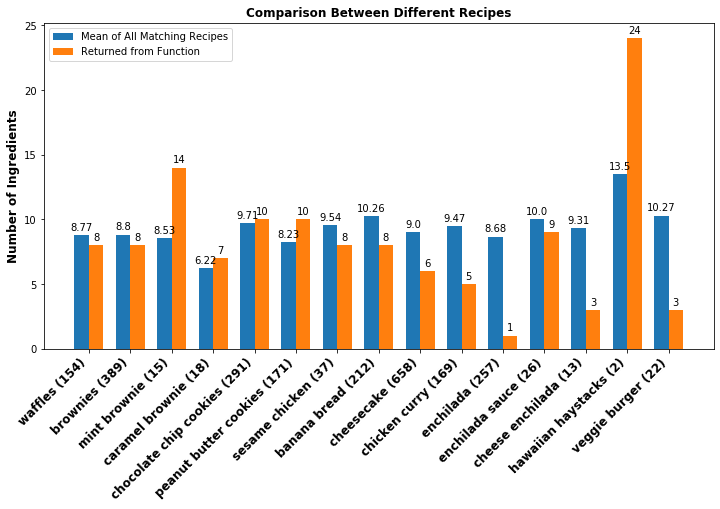

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = []
all_recipes_mean = []
returned_recipe_mean = []

for i in range(len(recipes_to_graph)):
    labels.append(recipes_to_graph[i][0])
    all_recipes_mean.append(recipes_to_graph[i][1])
    returned_recipe_mean.append(recipes_to_graph[i][2])

# labels = [x for x in recipes_to_graph[0]]
# all_recipes_mean = [x for x in recipes_to_graph[1]]
# returned_recipe_mean = [x for x in recipes_to_graph[2]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
rects1 = ax.bar(x - width/2, all_recipes_mean, width, label='Mean of All Matching Recipes')
rects2 = ax.bar(x + width/2, returned_recipe_mean, width, label='Returned from Function')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Ingredients', fontsize='large', fontweight='bold')
ax.set_title('Comparison Between Different Recipes', fontsize='large', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=45, ha='right')
ax.set_xticklabels(labels, fontsize='large', fontweight='bold')
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

# fig.tight_layout()

plt.show()